In [1]:
import rasterio as rio
from pathlib import Path
import numpy as np
from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask, get_s2_evalscript, get_timestamps
import matplotlib.pyplot as plt

C:\Users\oriol.alas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


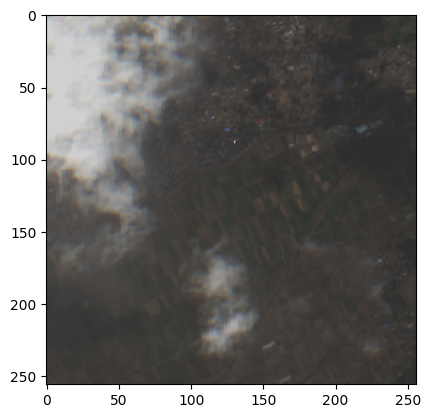

In [2]:
path = Path('../../imgs')
images = {p.name: p  for p in path.iterdir()}
path_img = [im for im in images['s2_cloudy'].iterdir()][0]
rio_cloudy = rio.open(path_img)
path_img = [im for im in images['s2'].iterdir()][0]
rio_cloudless = rio.open(path_img)

def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0, 255)).astype(np.uint8)

def sigmoid(x):
    return 255 / (1 + np.exp(-3 * (scaled(x) / 255 - 0.5)))

def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

cloudy = get_tci(rio_cloudy)
cloudless = get_tci(rio_cloudless)
plt.imshow(cloudy)

In [3]:
cloud_detector = S2PixelCloudDetector(threshold=0.7, average_over=4, dilation_size=2, all_bands=True)

In [4]:
def get_detect_cloud_bands(img):
    bands = [img.read(b) / 10000 for b in img.indexes]
    bands = np.stack(bands)
    return bands.transpose(1,2,0)

cloudy_bands = get_detect_cloud_bands(rio_cloudy)

0.5414216


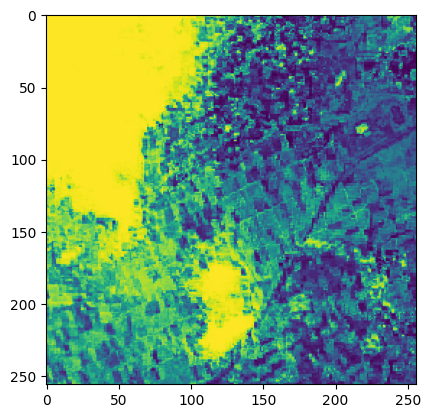

In [5]:
cloudy_mask = cloud_detector.get_cloud_probability_maps(cloudy_bands[np.newaxis, ...])
print(cloudy_mask.mean())
plt.imshow(cloudy_mask[0])

0.34149169921875


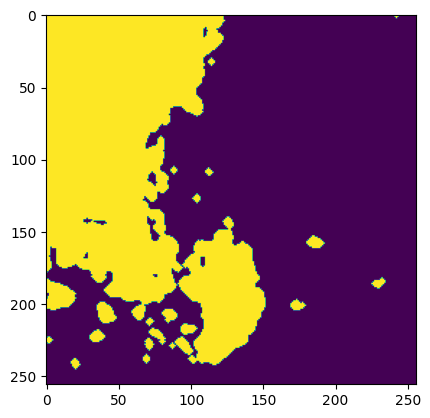

In [6]:
cloudy_mask = cloud_detector.get_cloud_masks(cloudy_bands[np.newaxis, ...])
print(cloudy_mask.mean())
plt.imshow(cloudy_mask[0])

# No guardaria imshow, guardaria l'array amb el path per poder fer la visualització pertinent.

In [7]:
path_imgs = [im for im in images['s2_cloudy'].iterdir()]
rio_cloudies = [rio.open(path) for path in path_imgs]

cloudy_bands_batch = [get_detect_cloud_bands(rio_cloudy) for rio_cloudy in rio_cloudies]
cloudy_masks_batch = cloud_detector.get_cloud_masks(np.array(cloudy_bands_batch))

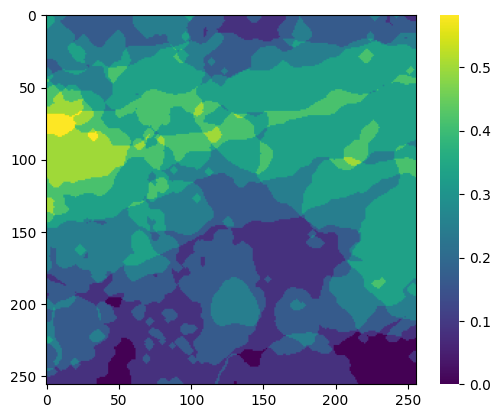

In [17]:
fig, ax = plt.subplots()
im = plt.imshow(cloudy_masks_batch.mean(0))
cbar = ax.figure.colorbar(im)
cbar.outline.set_visible(False)
cbar.ax.plot([0, 1], [3, 3], 'k', label="Ref")

In [107]:
(cloudy_mask[0] == 1).sum() + (cloudy_mask[0] == 0).sum() == (cloudy_mask[0]).reshape(-1).shape[0]

True

In [95]:
from sklearn.metrics import mean_squared_error

In [121]:
def get_mask_crop_correlation(cloudy_bands, cloudy_mask):
    bands = {}
    for band in range(cloudy_bands.shape[-1]):
        cloudy_crop = cloudy_bands[:,:, band][cloudy_mask > 0.5]
        mask_crop = cloudy_mask[cloudy_mask > 0.5]
        bands[f"band_{band + 1}"] = mean_squared_error(cloudy_crop, mask_crop)
    return bands

corrs = get_mask_crop_correlation(cloudy_bands, cloudy_mask[0])

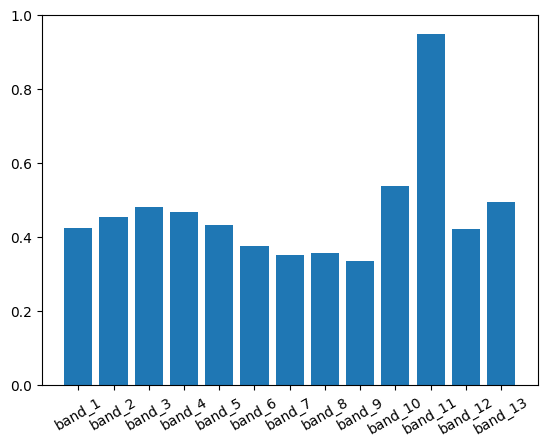

In [122]:
plt.bar(corrs.keys(), corrs.values())
plt.ylim([0, 1])
plt.xticks(rotation=30)
plt.show()

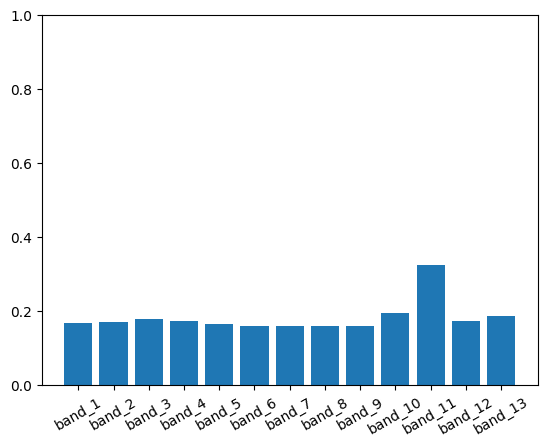

In [119]:
def get_cloud_correlation(cloudy_bands, cloudy_mask):
    bands = {}
    for band in range(cloudy_bands.shape[-1]):
        cloudy_crop = cloudy_bands[:,:, band].reshape(-1)
        mask_crop = cloudy_mask.reshape(-1)
        bands[f"band_{band + 1}"] = mean_squared_error(cloudy_crop, mask_crop)
    return bands
corrs = get_cloud_correlation(cloudy_bands, cloudy_mask[0])
plt.bar(corrs.keys(), corrs.values())
plt.ylim([0, 1])
plt.xticks(rotation=30)
plt.show()